# Neural Style Transfer

In [ ]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
imsize = 512  

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.CenterCrop(imsize),
    transforms.ToTensor()]) 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_1 = image_loader('/content/gdrive/My Drive/pictures/11.jpg')
style_3 = image_loader('/content/gdrive/My Drive/pictures/22.jpg')

girl_cont_3 = image_loader('/content/gdrive/My Drive/pictures/girl_cont_3.jpg')
man_cont = image_loader('/content/gdrive/My Drive/pictures/man_cont.jpg')


apart_style = image_loader('/content/gdrive/My Drive/pictures/apart_style.jpg')
apart_content = image_loader('/content/gdrive/My Drive/pictures/apart_content.jpg')

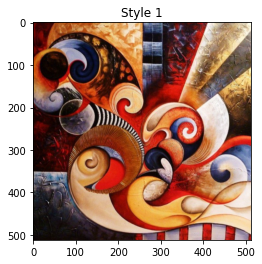

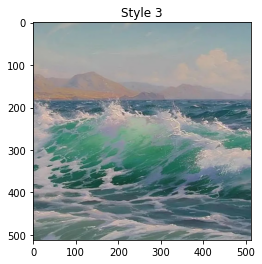

In [ ]:
unloader = transforms.ToPILImage()

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_1, title='Style 1')

plt.figure()
imshow(style_3, title='Style 3')

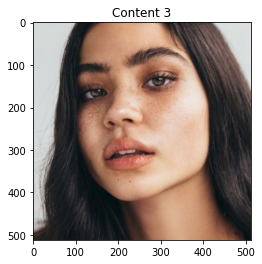

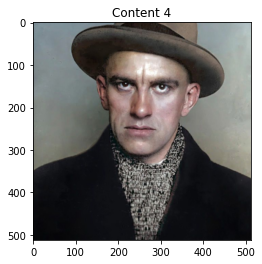

In [ ]:
plt.figure()
imshow(girl_cont_3, title='Content 3')

plt.figure()
imshow(man_cont, title='Content 4')

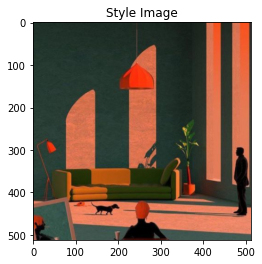

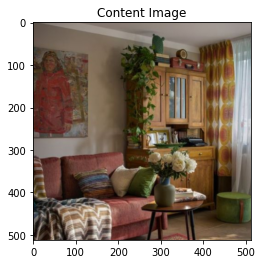

In [ ]:
plt.figure()
imshow(apart_style, title='Style Image')

plt.figure()
imshow(apart_content, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target, mode):
            super(ContentLoss, self).__init__()

            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [ ]:
def gram_matrix_old(input):
        batch_size , h, w, f_map_num = input.size()

        features = input.view(batch_size * h, w * f_map_num)

        G = torch.mm(features, features.t())  
        return G.div(batch_size * h * w * f_map_num)

In [ ]:
def gram_matrix(input, mode):
        dimensions = input.shape
        width_cutoff = dimensions[3] // 2

        left = input[:, :, :, :width_cutoff]
        right = input[:, :, :, width_cutoff:]
        
        if mode == 'left':
            batch_size , h, w, f_map_num = left.size()  
            features = left.reshape(batch_size * h, w * f_map_num)  
            G = torch.mm(features, features.t())  

        else:
            batch_size , h, w, f_map_num = right.size()  
            features = right.reshape(batch_size * h, w * f_map_num) 
            G = torch.mm(features, features.t())  

        return G.div(batch_size * h * w * f_map_num)

In [ ]:
class StyleLoss_weights(nn.Module):
        def __init__(self, target_feature_1, w1, target_feature_2, w2):
            super(StyleLoss_weights, self).__init__()
            self.target = w1 * gram_matrix_old(target_feature_1).detach() + w2 * gram_matrix_old(target_feature_2).detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            G = gram_matrix_old(input)
            self.loss = F.mse_loss(G, self.target)
            return input

In [ ]:
class StyleLoss_halves(nn.Module):
        def __init__(self, target_feature_1, target_feature_2):
            super(StyleLoss_halves, self).__init__()

            self.target_left = gram_matrix(target_feature_1, 'left').detach() 
            self.target_right = gram_matrix(target_feature_2, 'right').detach()
            self.loss = F.mse_loss(self.target_left, self.target_right)

        def forward(self, input):
            G_left = gram_matrix(input, 'left')
            G_right = gram_matrix(input, 'right')
            self.loss = F.mse_loss(G_left, self.target_left) + F.mse_loss(G_right, self.target_right)
            return input

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()

            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img_1, style_img_2, content_img, w1, w2,
                               mode, content_layers=content_layers_default, style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0  
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target, 'left')
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss) 

            if name in style_layers:
                if mode == 'option_1':
                  target_feature_1 = model(style_img_1).detach()
                  target_feature_2 = model(style_img_2).detach()
                  style_loss = StyleLoss_halves(target_feature_1, target_feature_2)
                  model.add_module("style_loss_{}".format(i), style_loss)
                  style_losses.append(style_loss)
                else:
                  target_feature_1 = model(style_img_1).detach()
                  target_feature_2 = model(style_img_2).detach()
                  style_loss = StyleLoss_weights(target_feature_1, w1, target_feature_2, w2)
                  model.add_module("style_loss_{}".format(i), style_loss)
                  style_losses.append(style_loss)
        if mode == 'option_1':
          for i in range(len(model) - 1, -1, -1):
              if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss_halves):
                  break
        
        else:
          for i in range(len(model) - 1, -1, -1):
              if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss_weights):
                  break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img_1, style_img_2, input_img, w1, w2, mode, 
                       num_steps=350, style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img_1, style_img_2, content_img, w1, w2, mode)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]

        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
import warnings
warnings.filterwarnings('ignore')

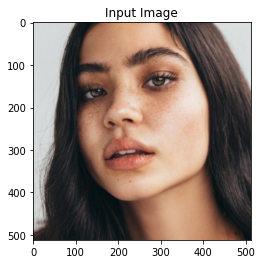

Building the style transfer model..
Optimizing..


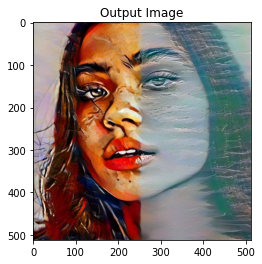

In [ ]:
input_img = girl_cont_3.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, girl_cont_3, style_1, style_3, input_img, 0.7, 0.3, 'option_1', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

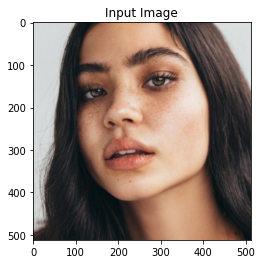

Building the style transfer model..
Optimizing..


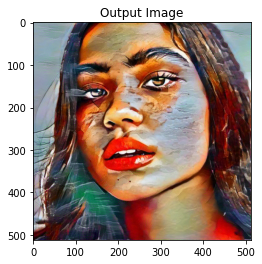

In [ ]:
input_img = girl_cont_3.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, girl_cont_3, style_1, style_3, input_img, 0.7, 0.3, 'option_2', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

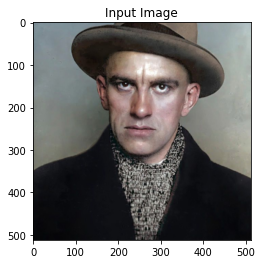

Building the style transfer model..
Optimizing..


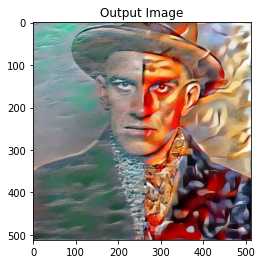

In [ ]:
input_img = man_cont.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, man_cont, style_3, style_1, input_img, 0.7, 0.3, 'option_1', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

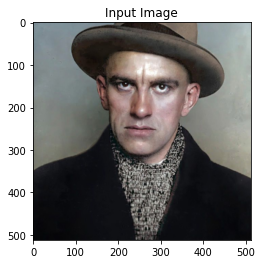

Building the style transfer model..
Optimizing..


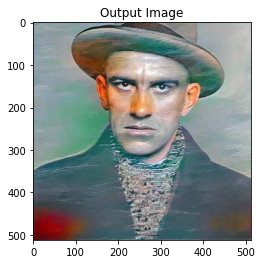

In [ ]:
input_img = man_cont.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, man_cont, style_3, style_1, input_img, 0.9, 0.1, 'option_2', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

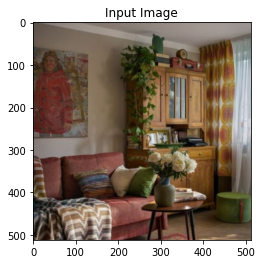

Building the style transfer model..
Optimizing..


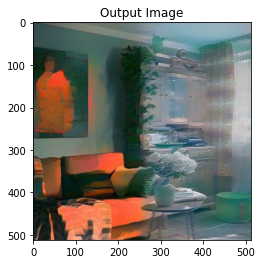

In [ ]:
input_img = apart_content.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, apart_content, apart_style, style_3, input_img, 0.7, 0.3, 'option_1', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

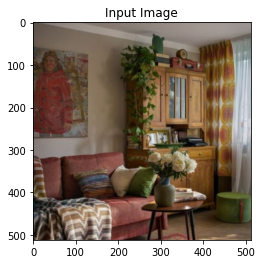

Building the style transfer model..
Optimizing..


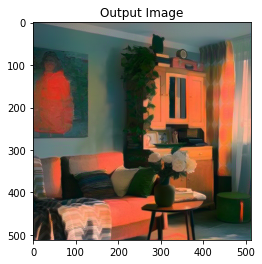

In [ ]:
input_img = apart_content.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, apart_content, apart_style, style_3, input_img, 0.9, 0.1, 'option_2', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

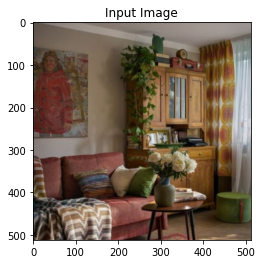

Building the style transfer model..
Optimizing..


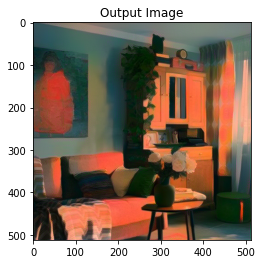

In [ ]:
input_img = apart_content.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, apart_content, apart_style, apart_style, input_img, 0.7, 0.3, 'option_2', num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()